In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import os
from numpy import genfromtxt
from keras import backend as K
import numpy as np
from keras.layers import Input, Lambda, Conv2D
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Lambda, Flatten, Dense


In [ ]:
import os
from collections import defaultdict
import cv2
import numpy as np
import tensorflow

from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
# from keras.engine.topology import Layer
from tensorflow.keras import layers
from keras import backend as K
K.set_image_data_format('channels_first')
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
# from inception_block_model.py import imgRecoModel

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [ ]:
def get_data_dic(path, train=True):
    dic_data = defaultdict(list)
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        name = str(ID) + '_' + lr + '_' + finger
        dic_data[name].append(os.path.join(path, img))
    return dic_data

In [ ]:
altered_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered'
real_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Real'

dic_alt_easy = get_data_dic(altered_path + '-Easy')
dic_alt_hard = get_data_dic(altered_path + '-Hard')
dic_alt_med = get_data_dic(altered_path + '-Medium')
dic_real = get_data_dic(real_path, train=False)

In [ ]:
def merge_data(dic1, dic2, dic3):

    for k2, v2 in dic2.items():
        dic1[k2] = dic1[k2] + v2

    for k3, v3 in dic3.items():
        dic1[k3] = dic1[k3] + v3

    return dic1

In [ ]:
dic_data = merge_data(dic_alt_easy, dic_alt_hard, dic_alt_med)

In [ ]:

dict1 = {key: dic_data[key] for key in list(dic_data.keys())[:5000]}
dict2 = {key: dic_data[key] for key in list(dic_data.keys())[5000:]}

In [ ]:
dic_data=dict1

In [ ]:
test_dict=dict2

In [ ]:
ids = list(test_dict.keys())
len(ids)

1000

In [ ]:

def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euc_dist_out_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

def build_network(network, input_shape):
  f_inp = Input(input_shape, name='first_input')
  s_inp = Input(input_shape, name='second_input')

  f_enc = network(f_inp)
  s_enc = network(s_inp)

  output_layer = Lambda(euclidean_distance, output_shape=euc_dist_out_shape)([f_enc, s_enc])
  model = Model(inputs=[f_inp, s_inp], outputs=output_layer)
  return model

In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [ ]:
def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )


def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1/ (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


1/1 [==============================] - 7s 7s/step


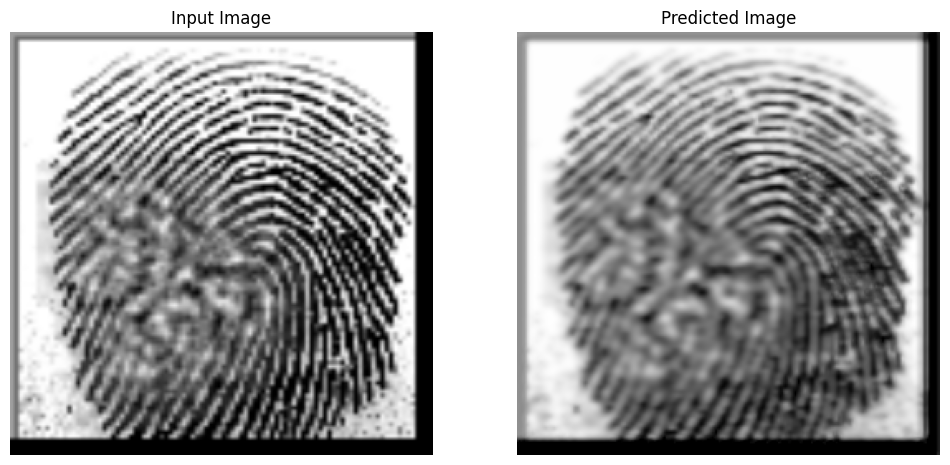

Predicted image saved at: /content/sample_data/predicted_image1.BMP


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load the SRCNN model
model = load_model('/content/drive/MyDrive/Model/srcnn_model_random_img.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/SOCOFing/SOCOFing/Altered/Altered-Hard/100__M_Left_index_finger_Obl.BMP'  # Replace with the path to your input image
input_image = cv2.imread(input_image_path)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (256, 256))
input_image = input_image.astype('float32') / 255.0

# Predict the high-resolution image
input_array = np.expand_dims(input_image, axis=0)
predicted_image = model.predict(input_array)[0]

# Display the input and predicted images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Image')
plt.imshow(predicted_image)
plt.axis('off')

plt.show()

# Save the predicted image
output_image_path = '/content/sample_data/predicted_image1.BMP'  # Replace with the desired output path
cv2.imwrite(output_image_path, cv2.cvtColor((predicted_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print("Predicted image saved at:", output_image_path)

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import Image, display
from PIL import Image

real_min_alt_dist=[]
real_min_enhAlt_dist=[]
enhReal_min_enhAlt_dist=[]

# Load the saved model
model = load_model('/content/drive/MyDrive/Model/srcnn_model_random_img.h5', custom_objects={'pixel_mse_loss': pixel_mse_loss, 'PSNR': PSNR})

# Load another model (assuming you have defined 'p' elsewhere in your code)
p = load_model('/content/drive/MyDrive/Model/model_siamese_git_with_testSplit.h5')




def compute_distance(real_image_path, alt_image_path):
    anc_img_path = real_image_path
    pos_img_path = alt_image_path

    anc_img = np.around(np.transpose(cv2.resize(cv2.imread(anc_img_path), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    pos_img = np.around(np.transpose(cv2.resize(cv2.imread(pos_img_path), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)




    #neg_img = np.clip(model.predict(np.expand_dims(img_to_array(cv2.imread(pos_img_path)), axis=0)), 0.0, 1.0)[0]

    input_image = cv2.imread(anc_img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (256, 256))
    input_image = input_image.astype('float32') / 255.0

# Convert the input image to a NumPy array
   # input_array = img_to_array(input_image)
    #print(input_array.shape)
# Predict the high-resolution image
    #input_array_transposed = np.transpose(input_array, (1, 2, 0))  # Transpose dimensions
    #print(input_array_transposed.shape)
    input_array=np.expand_dims(input_image, axis=0)
    anc_img1 = model.predict(input_array)[0]

   # Resize the image using the LANCZOS interpolation method
    #anc_img1 = Image.fromarray(np.uint8(input_image * 255))  # Convert NumPy array to Pillow Image
    #neg_img = input_image_pil.resize((desired_width, desired_height), Image.LANCZOS)


# Save the resized image (replace 'output_image_path' with the desired output path)
    output_image_path_anc = '/content/sample_data/predicted_image_anchor.BMP'
    # Ensure values are within the valid range [0, 1]
    anc_img1 = np.clip(anc_img1, 0.0, 1.0)

# Convert the image back to uint8 format (0-255)
    anc_img1 = (anc_img1 * 255).astype(np.uint8)

    cv2.imwrite(output_image_path_anc, anc_img1)
    ''' img = cv2.imread(pos_img_path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.0
    arrayImg=img_to_array(img)
    print(arrayImg)

    neg_img = np.clip(model.predict(arrayImg.reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    print(neg_img.shape)

    plt.imshow(neg_img)'''

    input_image = cv2.imread(pos_img_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (256, 256))
    input_image = input_image.astype('float32') / 255.0

# Convert the input image to a NumPy array
    #input_array = img_to_array(input_image)

# Predict the high-resolution image
    #input_array_transposed = np.transpose(input_array, (1, 2, 0))  # Transpose dimensions

    input_array=np.expand_dims(input_image, axis=0)
    neg_img = model.predict(input_array)[0]
   # Resize the image using the LANCZOS interpolation method
    #neg_img = Image.fromarray(np.uint8(input_image * 255))  # Convert NumPy array to Pillow Image
    #neg_img = input_image_pil.resize((desired_width, desired_height), Image.LANCZOS)


# Save the resized image (replace 'output_image_path' with the desired output path)
    output_image_path_neg = '/content/sample_data/predicted_image.BMP'
    neg_img = np.clip(neg_img, 0.0, 1.0)

# Convert the image back to uint8 format (0-255)
    neg_img = (neg_img * 255).astype(np.uint8)
    cv2.imwrite(output_image_path_neg, neg_img)
    # Replace 'image_data' with your image data as a NumPy array
    #image_data = cv2.imread('image.jpg')


   # Convert 'neg_img' to a Pillow Image object
     # Convert 'neg_img' to a NumPy array
    anc_img1 = np.around(np.transpose(cv2.resize(cv2.imread('/content/sample_data/predicted_image_anchor.BMP'), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    neg_img = np.around(np.transpose(cv2.resize(cv2.imread('/content/sample_data/predicted_image.BMP'), (96, 96)) / 255.0, (2, 0, 1)), decimals=6)
    pos_enc = p.predict_on_batch(np.expand_dims(pos_img, 0))
    anc_enc = p.predict_on_batch(np.expand_dims(anc_img, 0))
    neg_enc = p.predict_on_batch(np.expand_dims(neg_img, 0))
    anc_enc1 = p.predict_on_batch(np.expand_dims(anc_img1, 0))

    #print('Distance between real - altered: ', np.linalg.norm(anc_enc - pos_enc))
    real_min_alt_dist.append(np.linalg.norm(anc_enc - pos_enc))
    #print('Distance between real - enhanced altered: ', np.linalg.norm(anc_enc - neg_enc))
    real_min_enhAlt_dist.append(np.linalg.norm(anc_enc - neg_enc))
    #print('Distance between enhanced real - enhanced altered: ', np.linalg.norm(anc_enc1 - neg_enc))
    enhReal_min_enhAlt_dist.append(np.linalg.norm(anc_enc1 - neg_enc))
    #print(anc_img.shape)
    #print(pos_img.shape)
    #print(neg_img.shape)

'''    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))
    ax[0].title.set_text('Real Image')
    ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))
    ax[1].title.set_text('Altered Image')
    ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))
    ax[2].title.set_text('Enhanced Altered Image')
    #ax[3].imshow(np.transpose(anc_enc1, (1, 2, 0)))
    #ax[3].title.set_text('Enhanced Real Image')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()'''

"    fig, ax = plt.subplots(1, 3, figsize=(10, 4))\n    ax[0].imshow(np.transpose(anc_img, (1, 2, 0)))\n    ax[0].title.set_text('Real Image')\n    ax[1].imshow(np.transpose(pos_img, (1, 2, 0)))\n    ax[1].title.set_text('Altered Image')\n    ax[2].imshow(np.transpose(neg_img, (1, 2, 0)))\n    ax[2].title.set_text('Enhanced Altered Image')\n    #ax[3].imshow(np.transpose(anc_enc1, (1, 2, 0)))\n    #ax[3].title.set_text('Enhanced Real Image')\n    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])\n    plt.show()"

In [ ]:
#code for matching pairs

from tqdm import tqdm

prefix_to_extract = '/content/drive/MyDrive/SOCOFing/SOCOFing'

# Check if the input string contains the prefix to extract
ids = list(test_dict.keys())

# Create a tqdm instance to track progress
for id in tqdm(ids[:50]):
    input_stringList = test_dict[id]
    for input_string in input_stringList:
        if prefix_to_extract in input_string:
            # Extract the prefix part
            extracted_prefix = input_string.split(prefix_to_extract)[0] + prefix_to_extract

            # Extract the image name
            image_name = input_string.split(prefix_to_extract)[1].split('/')[-1]
            #print(image_name)
            # Remove undesired parts (e.g., "_CR.BMP")
            suffix = "_" + image_name.split('_')[-1]
            #print(suffix)
            if image_name.endswith(suffix):
                result_string = image_name.rstrip(suffix)
                result_string = result_string + '.BMP'
                #print(result_string)

            # Append the suffix to the prefix
            real_image_path = extracted_prefix + '/Real/' + result_string
            alt_image_path = input_string
            compute_distance(real_image_path, alt_image_path)


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 1/50 [00:10<08:45, 10.73s/it]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 2/50 [00:19<07:35,  9.48s/it]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 3/50 [00:26<06:34,  8.39s/it]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 4/50 [00:33<06:08,  8.01s/it]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 5/50 [00:41<06:01,  8.04s/it]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 6/50 [00:48<05:29,  7.49s/it]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 7/50 [00:55<05:13,  7.28s/it]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 8/50 [01:03<05:24,  7.73s/it]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 9/50 [01:11<05:10,  7.58s/it]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 10/50 [01:17<04:50,  7.27s/it]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 11/50 [01:25<04:50,  7.45s/it]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 12/50 [01:32<04:35,  7.26s/it]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 13/50 [01:39<04:25,  7.17s/it]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 14/50 [01:47<04:30,  7.51s/it]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 15/50 [01:56<04:32,  7.80s/it]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 16/50 [02:04<04:26,  7.84s/it]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 17/50 [02:11<04:09,  7.57s/it]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 18/50 [02:16<03:40,  6.88s/it]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 19/50 [02:21<03:21,  6.49s/it]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 20/50 [02:29<03:25,  6.84s/it]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 21/50 [02:35<03:10,  6.58s/it]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 22/50 [02:41<02:57,  6.35s/it]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 23/50 [02:50<03:15,  7.24s/it]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 24/50 [02:57<03:04,  7.09s/it]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 25/50 [03:06<03:11,  7.65s/it]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 26/50 [03:14<03:10,  7.94s/it]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 27/50 [03:23<03:03,  7.97s/it]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 28/50 [03:32<03:05,  8.44s/it]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 29/50 [03:41<03:01,  8.65s/it]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 30/50 [03:48<02:43,  8.18s/it]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 31/50 [03:58<02:41,  8.50s/it]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 32/50 [04:05<02:30,  8.34s/it]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 33/50 [04:15<02:28,  8.76s/it]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 34/50 [04:25<02:25,  9.08s/it]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 35/50 [04:34<02:15,  9.07s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 36/50 [04:42<02:02,  8.77s/it]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 37/50 [04:51<01:54,  8.84s/it]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 38/50 [05:00<01:46,  8.84s/it]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 39/50 [05:08<01:34,  8.63s/it]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 40/50 [05:17<01:28,  8.81s/it]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 41/50 [05:26<01:19,  8.83s/it]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 42/50 [05:35<01:10,  8.82s/it]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 43/50 [05:44<01:01,  8.83s/it]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 44/50 [05:52<00:52,  8.67s/it]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 45/50 [06:01<00:43,  8.77s/it]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 46/50 [06:10<00:35,  8.81s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 47/50 [06:19<00:26,  8.73s/it]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 48/50 [06:28<00:17,  8.81s/it]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 49/50 [06:37<00:08,  8.87s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 50/50 [06:46<00:00,  8.13s/it]


In [ ]:
print(len(real_min_alt_dist))
print(len(real_min_enhAlt_dist))
print(len(enhReal_min_enhAlt_dist))



402
402
402


In [ ]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = 403  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)


In [ ]:
len(numbers)

402

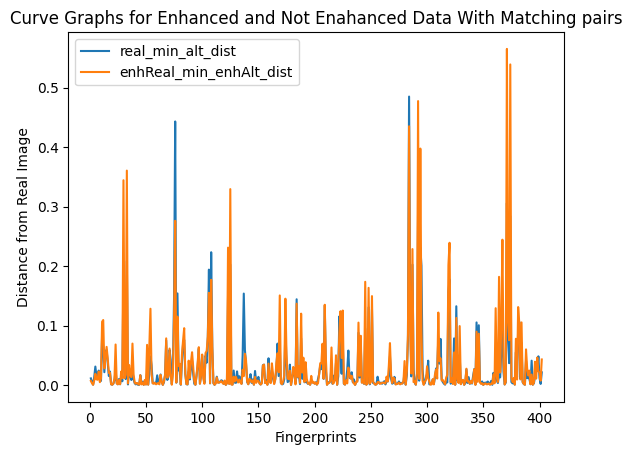

In [ ]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist
#y2_data = real_min_enhAlt_dist[:100]
y3_data = enhReal_min_enhAlt_dist

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Not Enahanced Data With Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()


In [ ]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=402
for dist1,dist2 in zip(real_min_alt_dist,enhReal_min_enhAlt_dist):
  if dist1>dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for matching pairs {negative_percent}")

178
224
postive_percent for matching pairs 44.27860696517413
negative_percent for matching pairs 55.72139303482587


In [ ]:
#code for non-matching pairs
import random
from tqdm import tqdm

prefix_to_extract = '/content/drive/MyDrive/SOCOFing/SOCOFing'

# Check if the input string contains the prefix to extract
ids = list(test_dict.keys())

# Create a tqdm instance to track progress
for id in tqdm(ids[:50]):
    input_stringList = test_dict[id]
    for input_string in input_stringList:
        if prefix_to_extract in input_string:
            # Extract the prefix part
            extracted_prefix = input_string.split(prefix_to_extract)[0] + prefix_to_extract

            # Extract the image name
            image_name = input_string.split(prefix_to_extract)[1].split('/')[-1]
            #print(image_name)
            # Remove undesired parts (e.g., "_CR.BMP")
            suffix = "_" + image_name.split('_')[-1]
            #print(suffix)
            if image_name.endswith(suffix):
                result_string = image_name.rstrip(suffix)
                result_string = result_string + '.BMP'
                #print(result_string)

            # Append the suffix to the prefix
            real_image_path = extracted_prefix + '/Real/' + result_string
            alt_image_path=input_string
            while alt_image_path==input_string:
              randomId=random.choice(ids)
              randomIdLength= len(test_dict[randomId])
              random_number = random.randint(0, randomIdLength-1)
              alt_image_path = test_dict[randomId][random_number]

            compute_distance(real_image_path, alt_image_path)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 1/50 [00:08<07:09,  8.77s/it]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 2/50 [00:15<06:05,  7.61s/it]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 3/50 [00:21<05:30,  7.03s/it]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 4/50 [00:29<05:37,  7.34s/it]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 5/50 [00:36<05:24,  7.21s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 6/50 [00:41<04:42,  6.41s/it]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 7/50 [00:47<04:25,  6.18s/it]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 8/50 [00:56<04:57,  7.08s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 9/50 [01:04<05:02,  7.37s/it]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 10/50 [01:11<04:50,  7.27s/it]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 11/50 [01:18<04:37,  7.12s/it]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 12/50 [01:24<04:21,  6.89s/it]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 13/50 [01:30<04:03,  6.59s/it]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 14/50 [01:38<04:11,  6.98s/it]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 15/50 [01:45<04:02,  6.92s/it]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 16/50 [01:52<04:02,  7.14s/it]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 17/50 [01:57<03:34,  6.49s/it]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 18/50 [02:01<03:06,  5.82s/it]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 19/50 [02:05<02:39,  5.16s/it]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 20/50 [02:10<02:31,  5.05s/it]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 21/50 [02:15<02:25,  5.02s/it]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 22/50 [02:19<02:11,  4.68s/it]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 23/50 [02:27<02:33,  5.67s/it]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 24/50 [02:31<02:18,  5.34s/it]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 25/50 [02:40<02:37,  6.31s/it]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 26/50 [02:47<02:39,  6.64s/it]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 27/50 [02:55<02:39,  6.94s/it]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 28/50 [03:02<02:34,  7.02s/it]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 29/50 [03:09<02:24,  6.88s/it]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 30/50 [03:15<02:11,  6.59s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 31/50 [03:23<02:13,  7.02s/it]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 32/50 [03:32<02:17,  7.62s/it]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 33/50 [03:41<02:16,  8.02s/it]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 34/50 [03:48<02:05,  7.85s/it]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 35/50 [03:56<01:59,  7.99s/it]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 36/50 [04:04<01:49,  7.81s/it]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 37/50 [04:12<01:45,  8.08s/it]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 38/50 [04:20<01:33,  7.81s/it]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 39/50 [04:27<01:23,  7.59s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 40/50 [04:35<01:19,  7.95s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 41/50 [04:44<01:13,  8.13s/it]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 42/50 [04:52<01:05,  8.19s/it]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 43/50 [05:00<00:56,  8.10s/it]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 44/50 [05:07<00:45,  7.66s/it]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 45/50 [05:15<00:38,  7.74s/it]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 46/50 [05:23<00:31,  7.95s/it]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 47/50 [05:31<00:24,  8.01s/it]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 48/50 [05:37<00:14,  7.39s/it]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 49/50 [05:45<00:07,  7.63s/it]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 50/50 [05:54<00:00,  7.09s/it]


In [ ]:
print(len(real_min_alt_dist))
print(len(real_min_enhAlt_dist))
print(len(enhReal_min_enhAlt_dist))

402
402
402


In [ ]:
numbers = []

# Define the range of numbers you want (from 1 to 3900 in this case)
start = 1
end = len(enhReal_min_enhAlt_dist)+1  # The 'end' value should be one more than the last number you want

# Use a for loop to generate the numbers and add them to the list
for num in range(start, end):
    numbers.append(num)

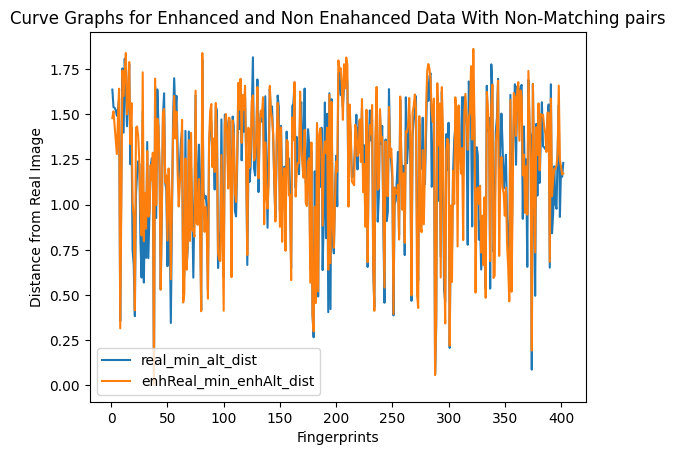

In [ ]:
import matplotlib.pyplot as plt

# Create your three lists of data
x_data = numbers
y1_data = real_min_alt_dist
#y2_data = real_min_enhAlt_dist
y3_data = enhReal_min_enhAlt_dist

# Plot the first dataset as a curve
plt.plot(x_data, y1_data, label='real_min_alt_dist', linestyle='-')

# Plot the second dataset as a curve
#plt.plot(x_data, y2_data, label='real_min_enhAlt_dist', linestyle='-')

# Plot the third dataset as a curve
plt.plot(x_data, y3_data, label='enhReal_min_enhAlt_dist', linestyle='-')

# Customize the plot (optional)
plt.xlabel('Fingerprints')
plt.ylabel('Distance from Real Image')
plt.title('Curve Graphs for Enhanced and Non Enahanced Data With Non-Matching pairs')
plt.legend()  # Show legend to distinguish between datasets

# Show the plot
plt.show()

In [ ]:
from numpy.ma.core import negative
positive_count=0
negative_count=0
total=len(enhReal_min_enhAlt_dist)
for dist1,dist2 in zip(real_min_alt_dist,enhReal_min_enhAlt_dist):
  if dist1<dist2:
    positive_count+=1
  else:
    negative_count+=1

print(positive_count)
print(negative_count)
postive_percent=(positive_count/total)*100
print(f"postive_percent for non-matching pairs {postive_percent}")
negative_percent= (negative_count/total)*100
print(f"negative_percent for non-matching pairs {negative_percent}")

211
191
postive_percent for non-matching pairs 52.48756218905473
negative_percent for non-matching pairs 47.51243781094527


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
TP=178
FP=224
TN=211
FN=191

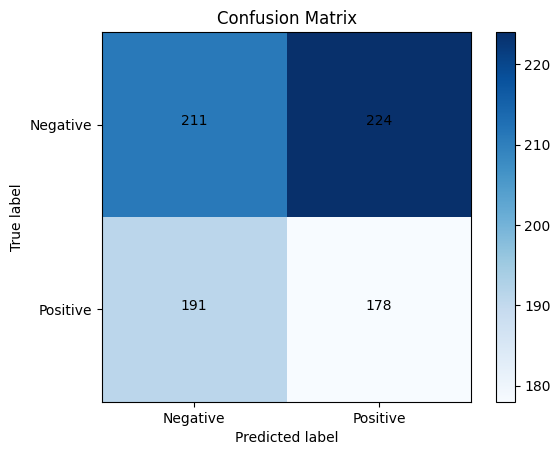

In [ ]:
confusion_matrix = np.array([[TN, FP], [FN, TP]])

# Define class labels
class_names = ['Negative', 'Positive']

# Create a heatmap
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Label the plot with the matrix values
thresh = confusion_matrix.max() / 2.
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, f'{confusion_matrix[i, j]}', horizontalalignment="center", color="black" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)


In [ ]:
print("Accuracy:", accuracy*100)

Accuracy: 48.383084577114424
